In [1]:
import os
os.chdir('/Users/rv/Projects/7CS074') # Change to the project root directory

import pandas as pd

import global_vars 

from sklearn.model_selection import train_test_split

from evaluation import select_best_model_cv
from features import engineer_features
from models import get_type_models

In [2]:
# First we will check and run the preprocessing script
# In case this is already done, this will not overwrite existing files
from preprocessing import process_raw_multiple_data_files

process_raw_multiple_data_files()

In [3]:
import numpy as np

if not os.path.exists(global_vars.DATASET_CLEAN_FILE_PATH):
    raise FileNotFoundError(f"Dataset not found at {global_vars.DATASET_CLEAN_FILE_PATH}. Please ensure the dataset is placed correctly.")

df = pd.read_csv(global_vars.DATASET_CLEAN_FILE_PATH, sep=',', engine='python') # read with proper delimiter handling, and with python engine always
if df.empty:
    raise ValueError("Loaded dataset is empty. Please check the dataset file.")

print(f"Data loaded successfully from {global_vars.DATASET_CLEAN_FILE_PATH}.")

target_col_class = 'price_category'

min_samples_per_make=300
cv_splits=5

trained_models_per_make = {}

df_copy = df.copy()
df_copy['price_category'] = pd.cut(
    df_copy['price'],
    bins=[0, 10000, 20000, 30000, np.inf],
    labels=['Budget', 'Mid-Range', 'Premium', 'Luxury']
)

# Remove rows with NaN price_category
df_copy = df_copy.dropna(subset=['price_category'])

Data loaded successfully from /Users/rv/Projects/7CS074/data/clean/cleaned_dataset.csv.


In [4]:
candidate_models = get_type_models('classification')

Y_global = df_copy[target_col_class]
X_global = engineer_features(
    df_copy,
    Y_global,
    global_vars.LOW_CATEGORICAL_FEATURES_OVERALL,
    global_vars.HIGH_CATEGORICAL_FEATURES_GLOBAL
)

global_X_train, global_X_test, global_y_train, global_y_test = train_test_split(
    X_global, Y_global, test_size=0.2, random_state=42, stratify=Y_global
)

global_best_name_model, global_best_model, global_cv_scores = select_best_model_cv(
    global_X_train, global_y_train, candidate_models, cv_splits=cv_splits, scoring='f1_weighted'
)

global_predictions = global_best_model.predict(global_X_test)
global_feature_names = global_X_train.columns

In [ ]:
# Per-make models
# If the length of each dataframe of group is lower than the minimum sample variable, we shall pass and not create a 'per-make' model
# This is to make sure that algorithms like 'Random Forrest' gets trained on larger sets of data, as indented, if the condition is true, the make would fallback into the global model above.
for make, group_df in df.groupby("make"):
	if len(group_df) < min_samples_per_make:
		continue

	df_make_copy = df_copy.loc[group_df.index]

	# Prepare features for classification
	Y = df_make_copy[target_col_class]
	X = engineer_features(
		df_make_copy,
		Y,
		global_vars.LOW_CATEGORICAL_FEATURES_OVERALL,
  		global_vars.HIGH_CATEGORICAL_FEATURES_PER_MAKE
	)

	X_train, X_test, y_train, y_test = train_test_split(
		X, Y, test_size=0.2, random_state=42, stratify=Y
	)

	best_name, best_model, cv_scores = select_best_model_cv(
		X_train, y_train, candidate_models, cv_splits=cv_splits, scoring='f1_weighted'
	)
 
	predictions = best_model.predict(X_test)

	trained_models_per_make[make] = {
		"best_model_name": best_name,
		"model": best_model,
		"feature_names": X_train.columns,
		"X_test": X_test,
		"y_test": y_test,
		"predictions": predictions,
	}

Make: audi, Best Model: random_forrest, y_test 18472       Luxury
20271    Mid-Range
18192    Mid-Range
20388       Luxury
20861      Premium
           ...    
17462       Luxury
20399      Premium
18925      Premium
21337      Premium
19542      Premium
Name: price_category, Length: 808, dtype: category
Categories (4, object): ['Budget' < 'Mid-Range' < 'Premium' < 'Luxury']
Make: bmw, Best Model: random_forrest, y_test 5336      Premium
6986    Mid-Range
7125       Luxury
4934       Luxury
6685       Budget
          ...    
5457      Premium
5632      Premium
4468    Mid-Range
4689    Mid-Range
6522       Luxury
Name: price_category, Length: 938, dtype: category
Categories (4, object): ['Budget' < 'Mid-Range' < 'Premium' < 'Luxury']
Make: ford, Best Model: random_forrest, y_test 24218    Mid-Range
27355    Mid-Range
26069    Mid-Range
25636       Budget
25256    Mid-Range
           ...    
25536    Mid-Range
26395       Budget
25565      Premium
26680       Budget
26897    Mid-Rang

In [6]:
from evaluation import classification_metrics

global_metrics = classification_metrics(global_y_test, global_predictions)

In [9]:
from evaluation import get_classification_report

print(f"\n Overall Dataset:")
print(f"  Best Model: {global_best_name_model}")
print(f"  Accuracy: {global_metrics['accuracy']:.3f}")
print(f"  Precision: {global_metrics['precision']:.3f}")
print(f"  Recall: {global_metrics['recall']:.3f}")
print(f"  F1-Score: {global_metrics['f1_score']:.3f}")

print(get_classification_report(
	global_y_test, 
	global_predictions, 
	target_names=['Budget', 'Mid-Range', 'Premium', 'Luxury']
))

for make_vehicle, data in trained_models_per_make.items():
	y_test = data['y_test']
	predictions = data['predictions']
	metrics = classification_metrics(y_test, predictions)

	print(f"\n{make_vehicle}:")
	print(f"  Best Model: {data['best_model_name']}")
	print(f"  Accuracy: {metrics['accuracy']:.3f}")
	print(f"  Precision: {metrics['precision']:.3f}")
	print(f"  Recall: {metrics['recall']:.3f}")
	print(f"  F1-Score: {metrics['f1_score']:.3f}")
 
	labels = y_test.cat.categories
	labels = [l for l in labels if l in y_test.unique()]
 
	print(get_classification_report(
		y_test, 
		predictions, 
		target_names=labels
	))


 Overall Dataset:
  Best Model: random_forrest
  Accuracy: 0.840
  Precision: 0.845
  Recall: 0.840
  F1-Score: 0.838
              precision    recall  f1-score   support

      Budget       0.89      0.79      0.84       892
   Mid-Range       0.88      0.61      0.72       790
     Premium       0.88      0.89      0.88      3088
      Luxury       0.77      0.87      0.82      2083

    accuracy                           0.84      6853
   macro avg       0.85      0.79      0.81      6853
weighted avg       0.84      0.84      0.84      6853


audi:
  Best Model: random_forrest
  Accuracy: 0.813
  Precision: 0.818
  Recall: 0.813
  F1-Score: 0.810
              precision    recall  f1-score   support

      Budget       0.00      0.00      0.00         2
   Mid-Range       0.88      0.73      0.79       186
     Premium       0.84      0.70      0.77       189
      Luxury       0.79      0.90      0.84       431

    accuracy                           0.81       808
   macro avg 

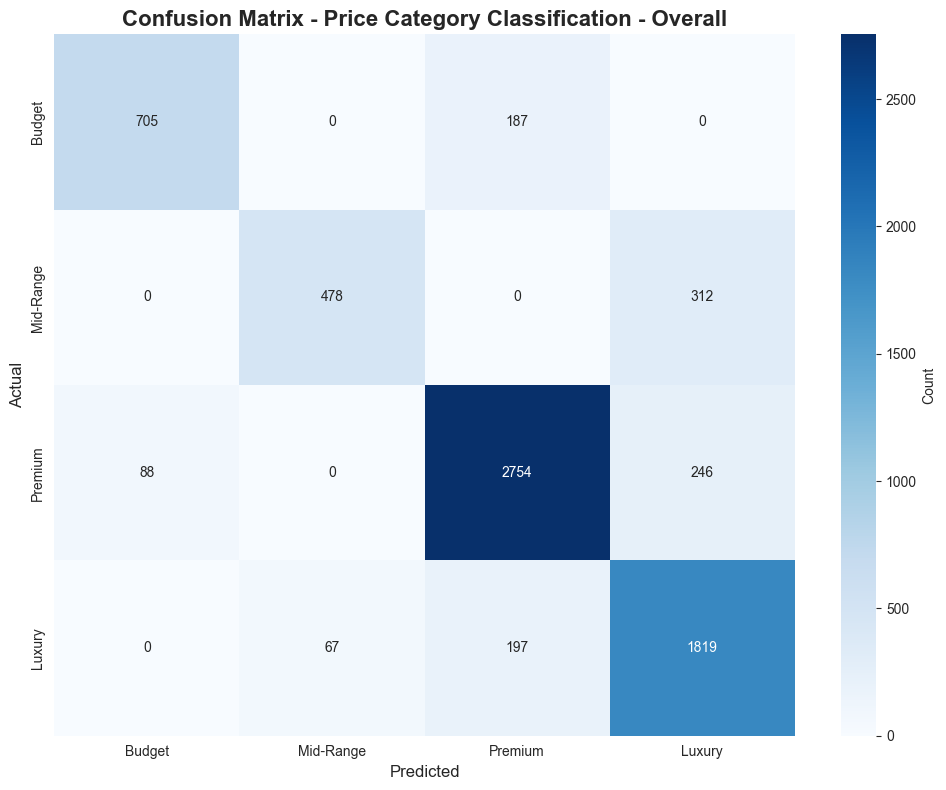

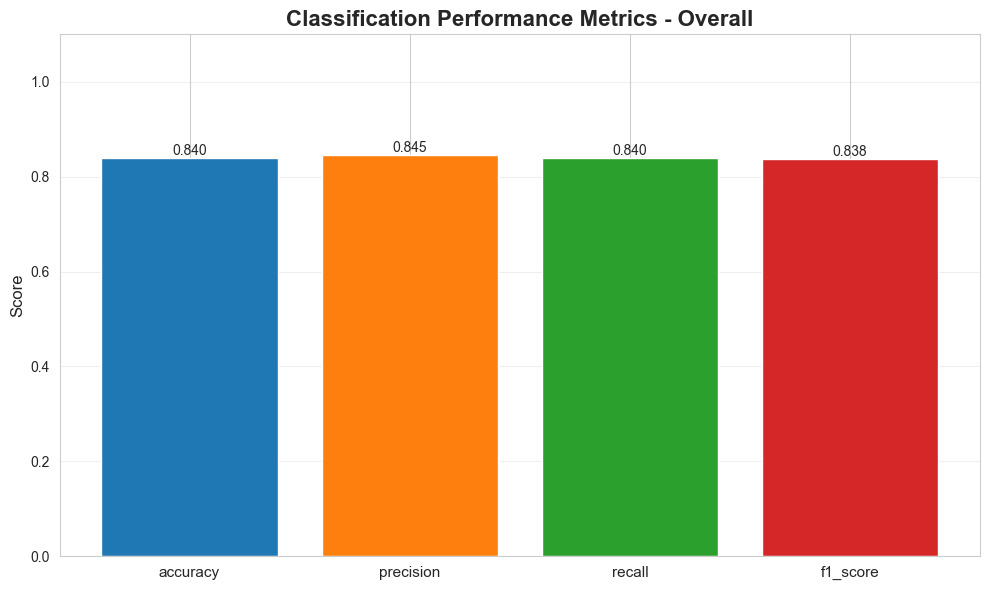

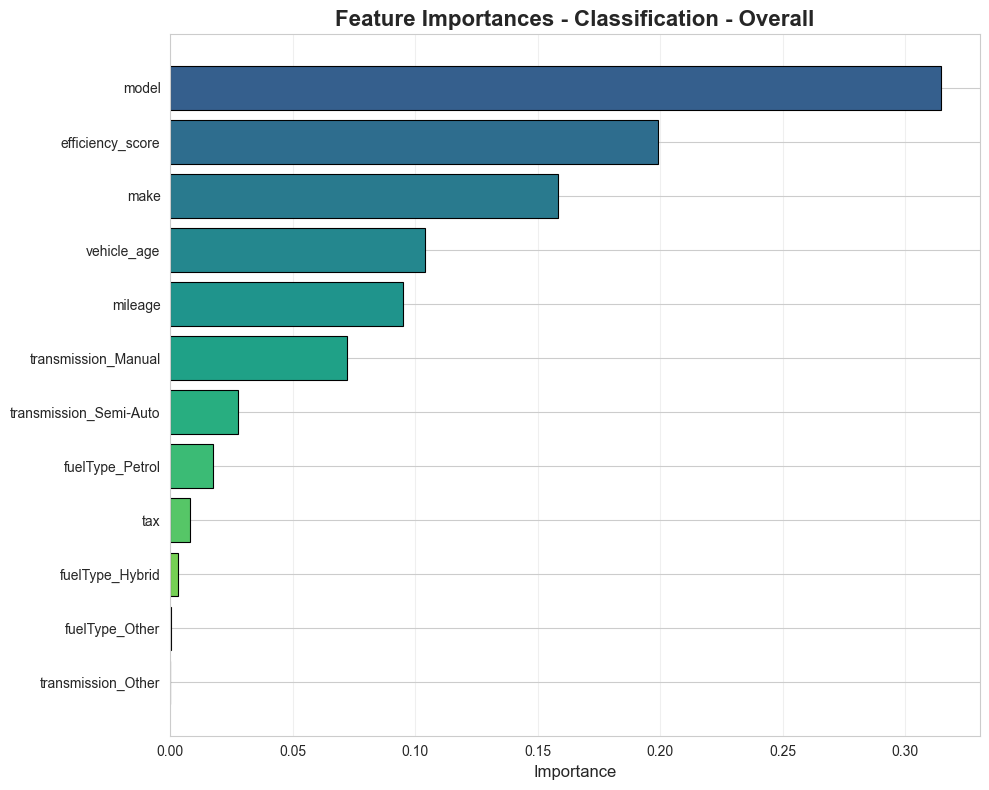

In [10]:
from features import get_feature_effects
from visualisation import plot_classification_metrics, plot_confusion_matrix, plot_feature_importances

plot_confusion_matrix(
	global_y_test, 
	global_predictions,
	labels=['Budget', 'Mid-Range', 'Premium', 'Luxury'],
	title=f"Confusion Matrix - Price Category Classification - Overall"
)

# Classification metrics bar chart
plot_classification_metrics(
	global_metrics,
	title=f"Classification Performance Metrics - Overall"
)

# Feature importances for classification
values_class, kind_class = get_feature_effects(global_best_model)
plot_feature_importances(
	values_class[:20],
	global_feature_names[:20],
	f"Feature {kind_class.title()}s - Classification - Overall"
)

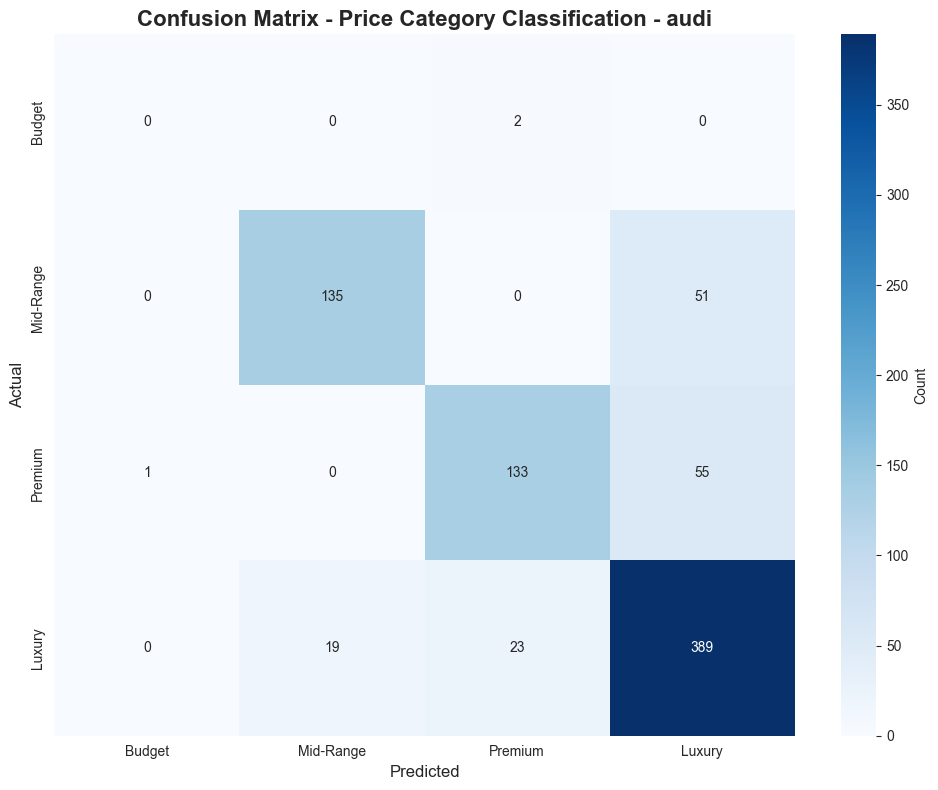

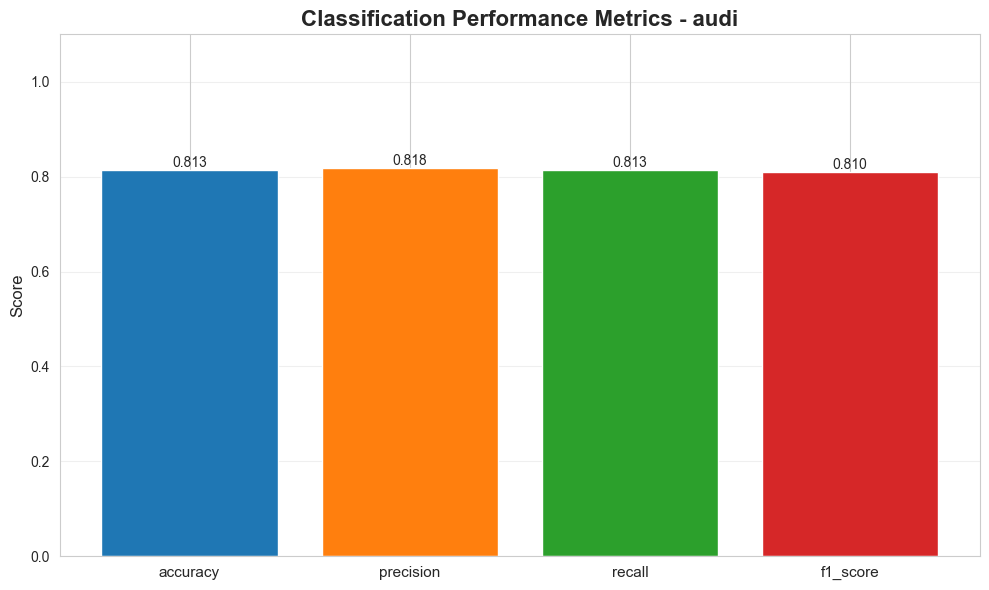

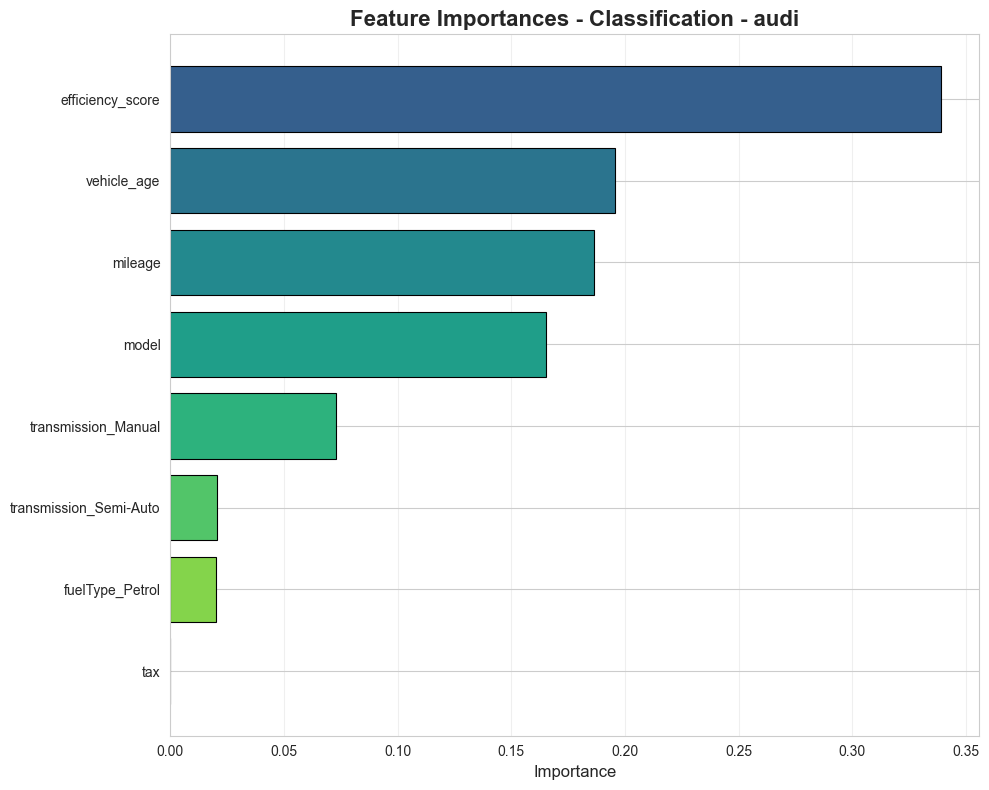

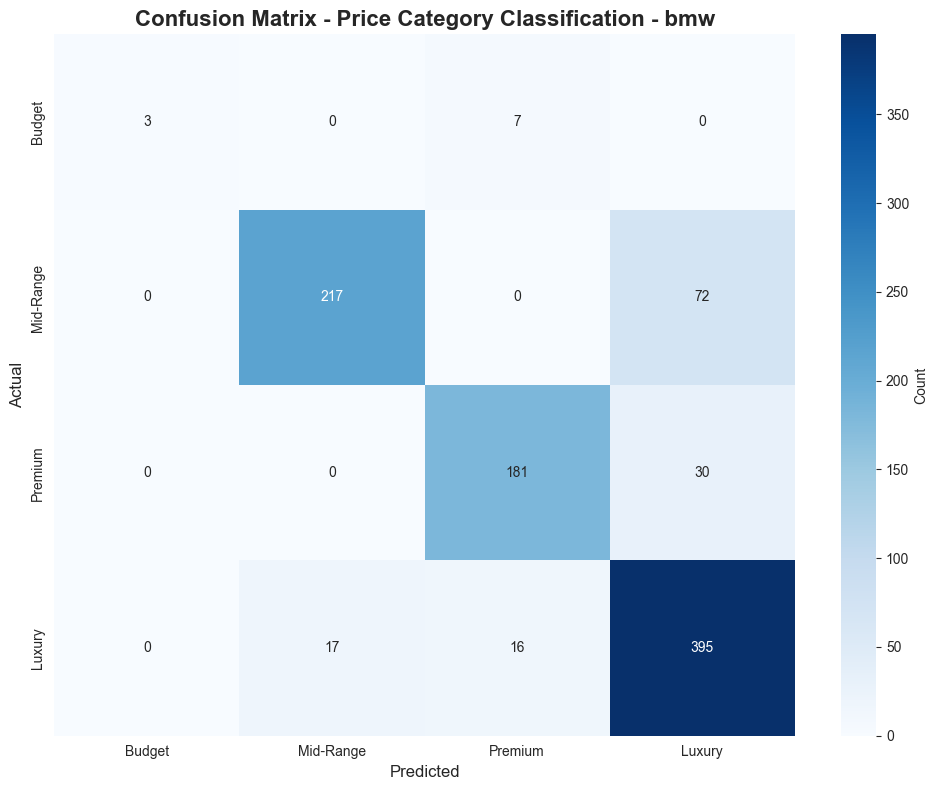

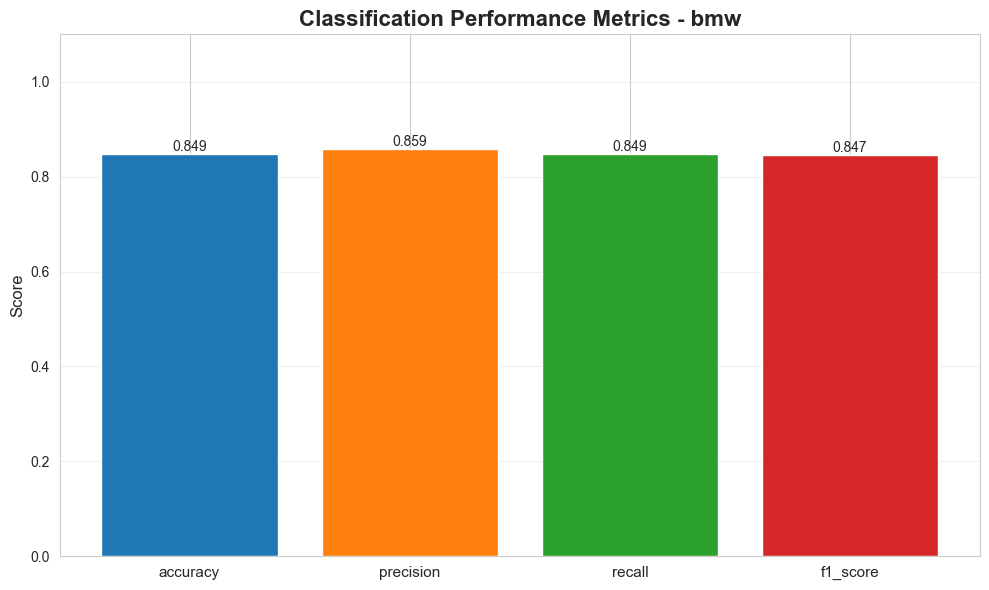

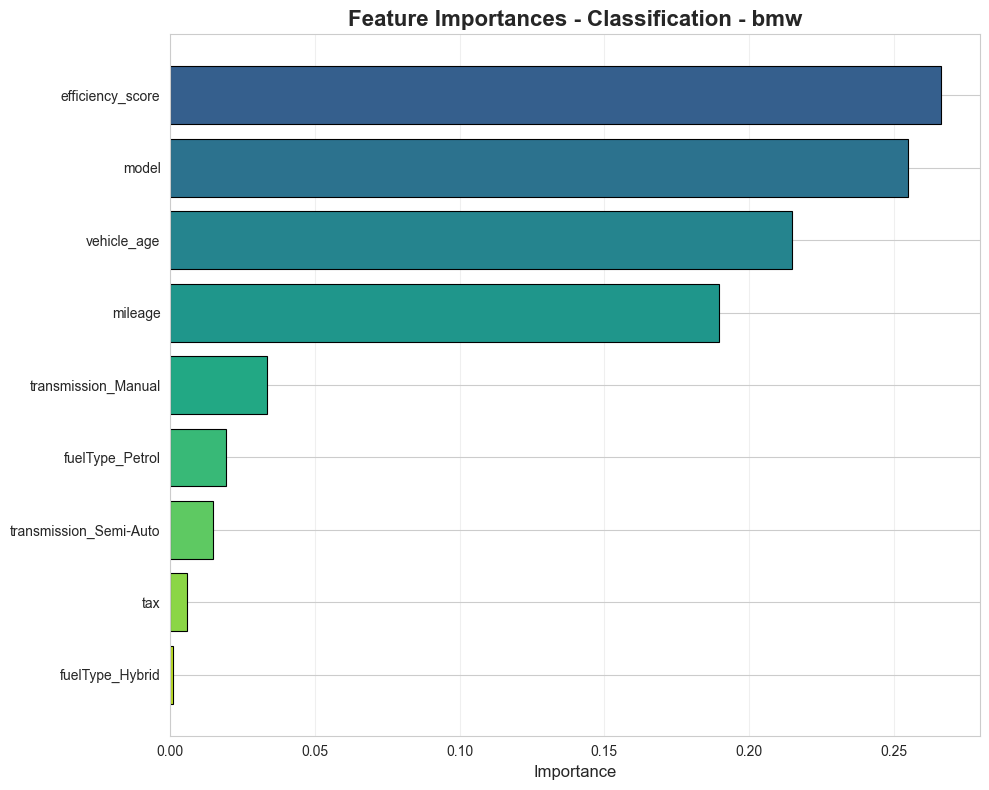

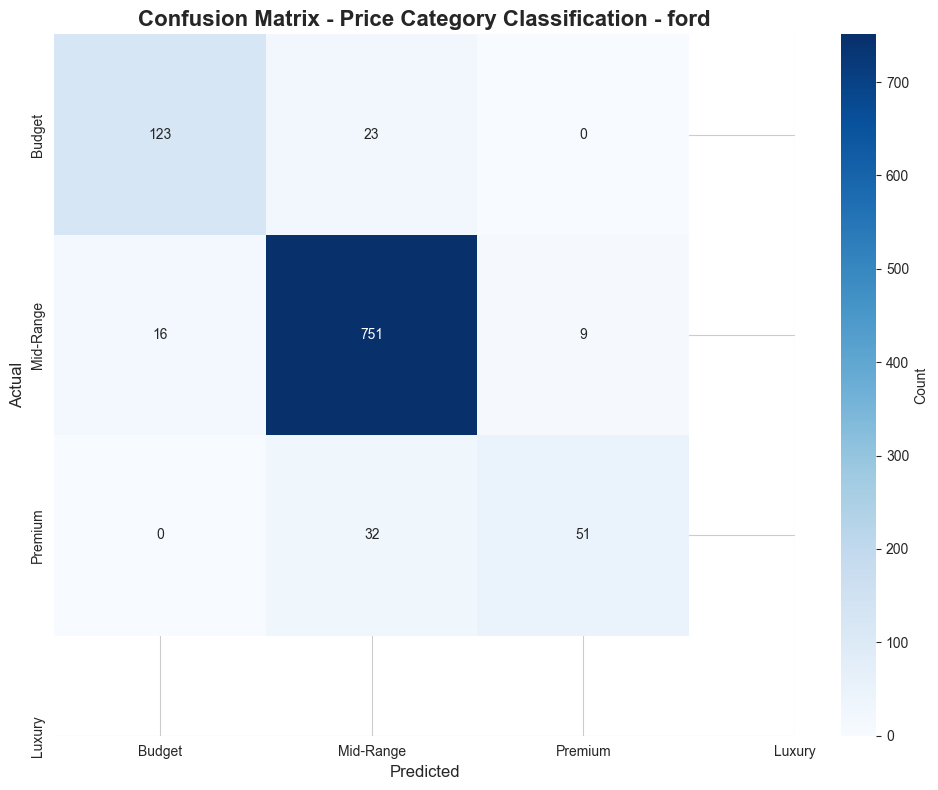

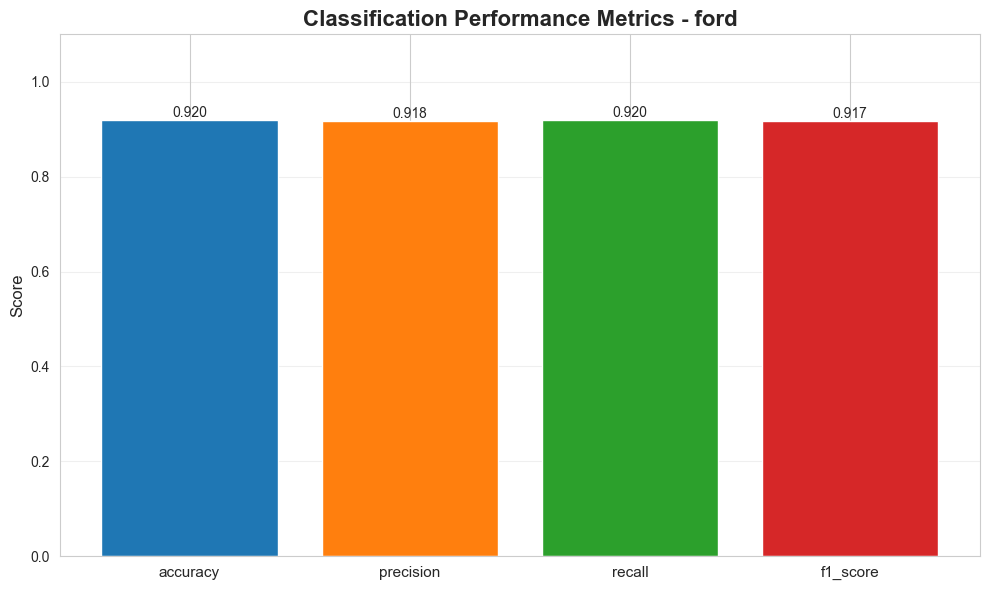

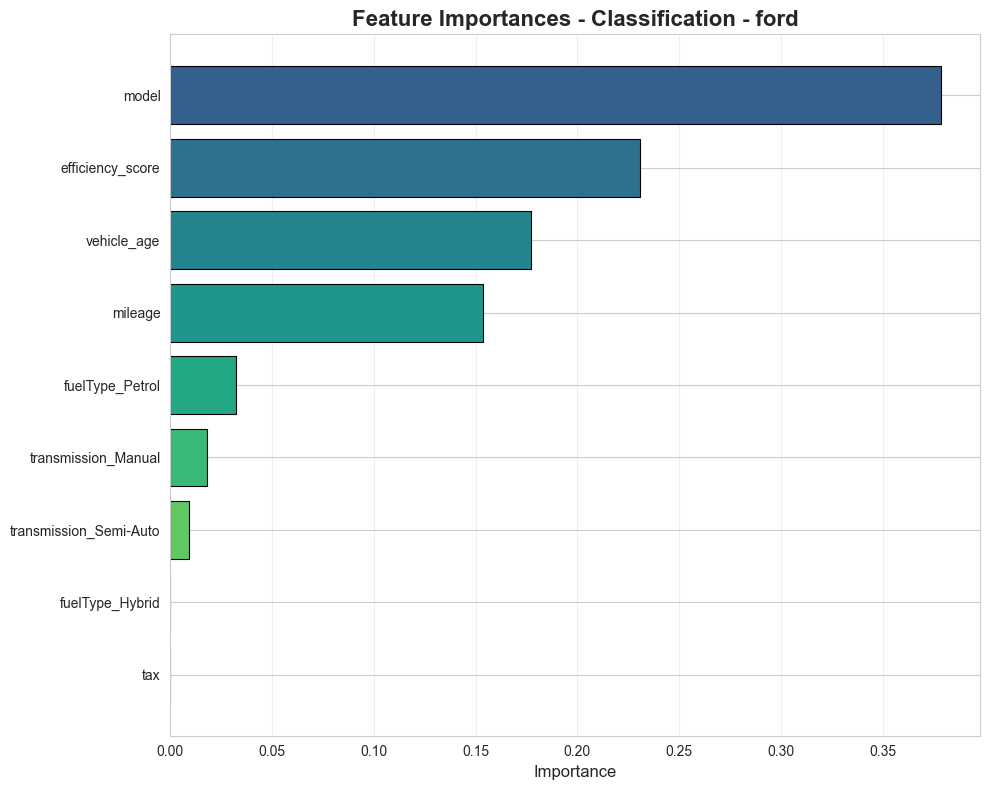

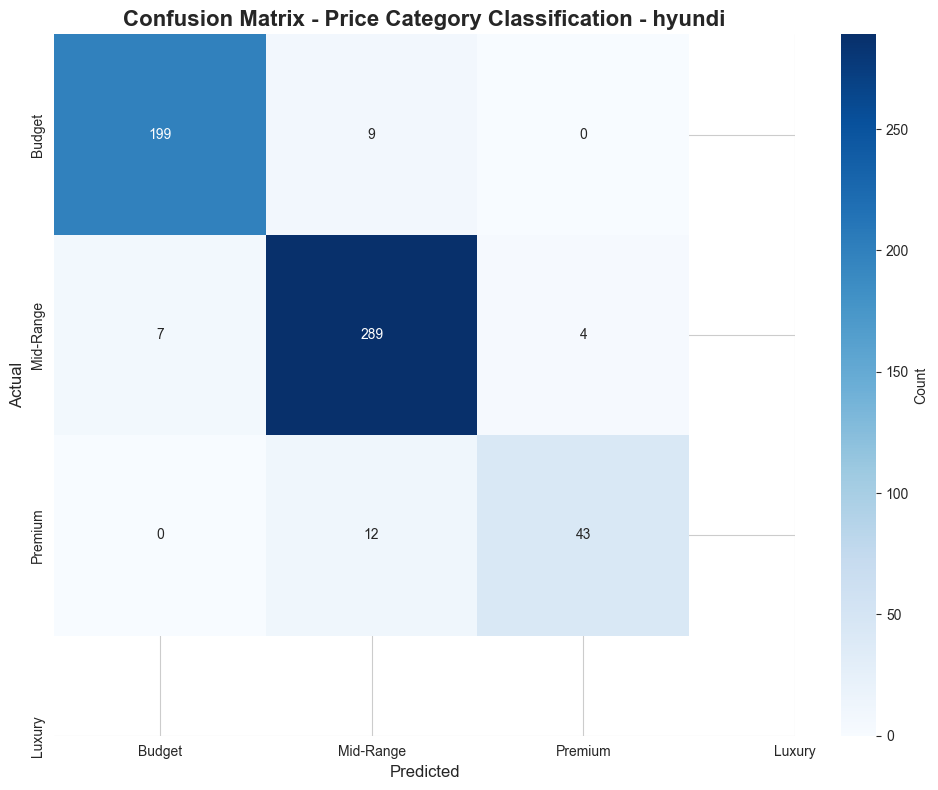

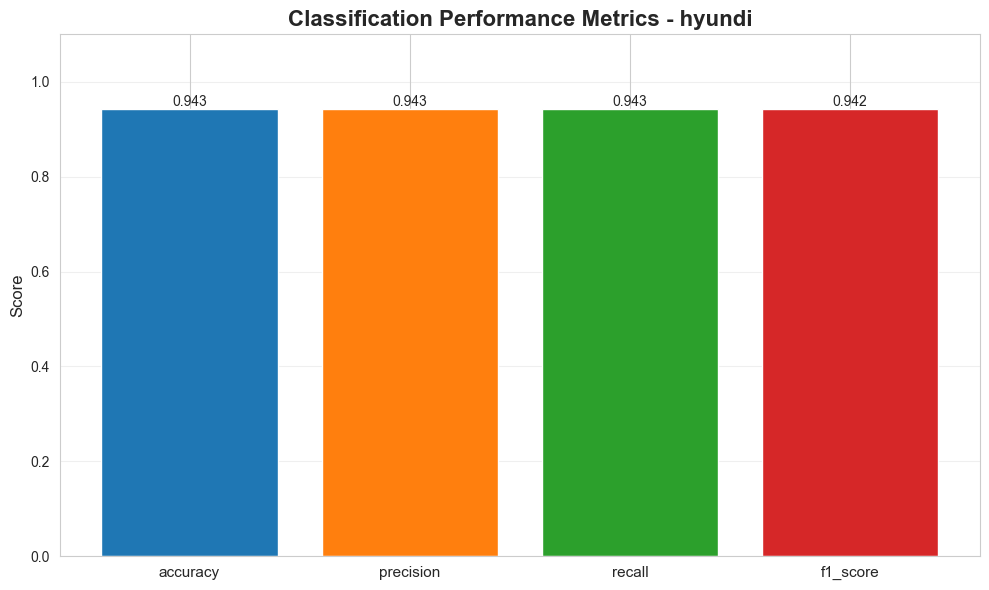

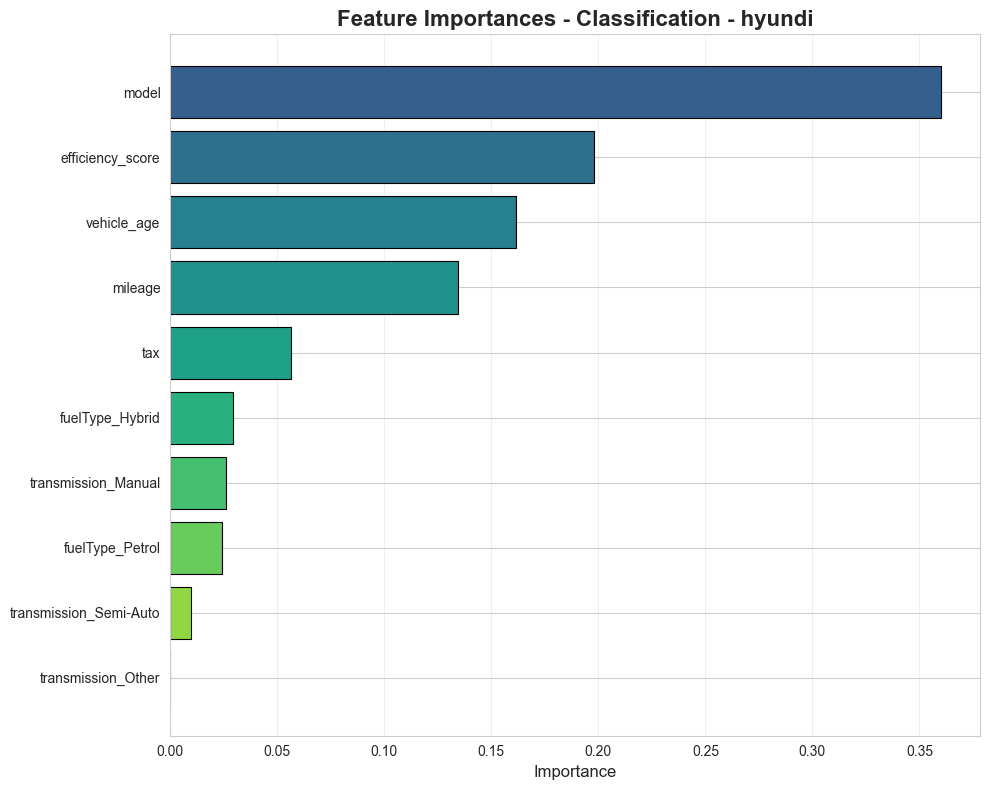

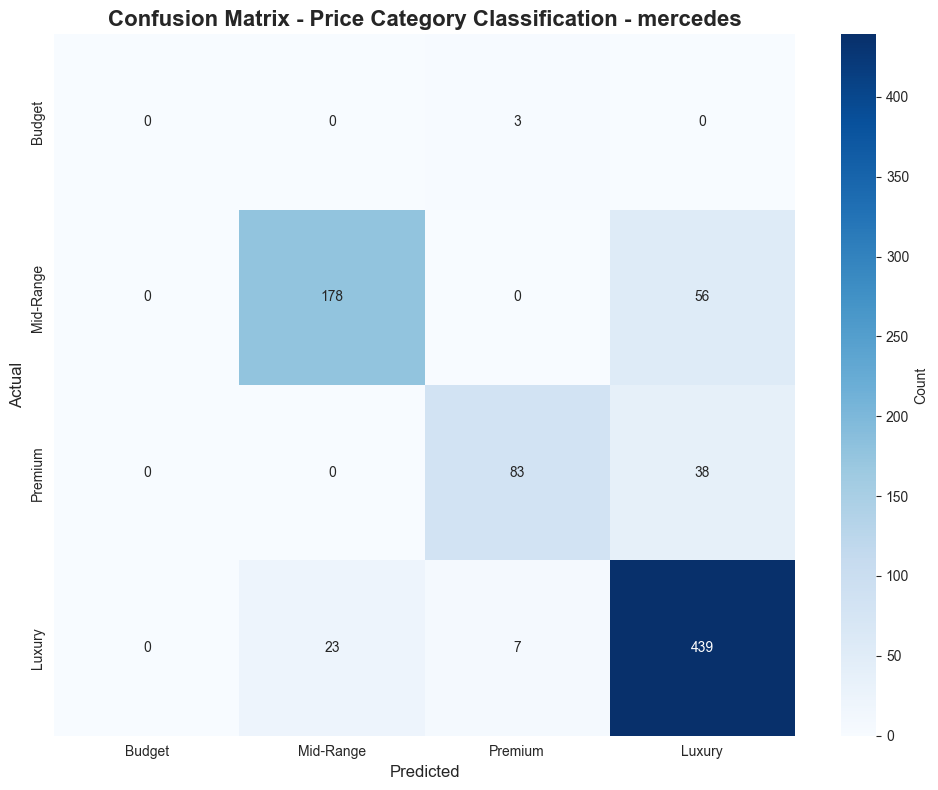

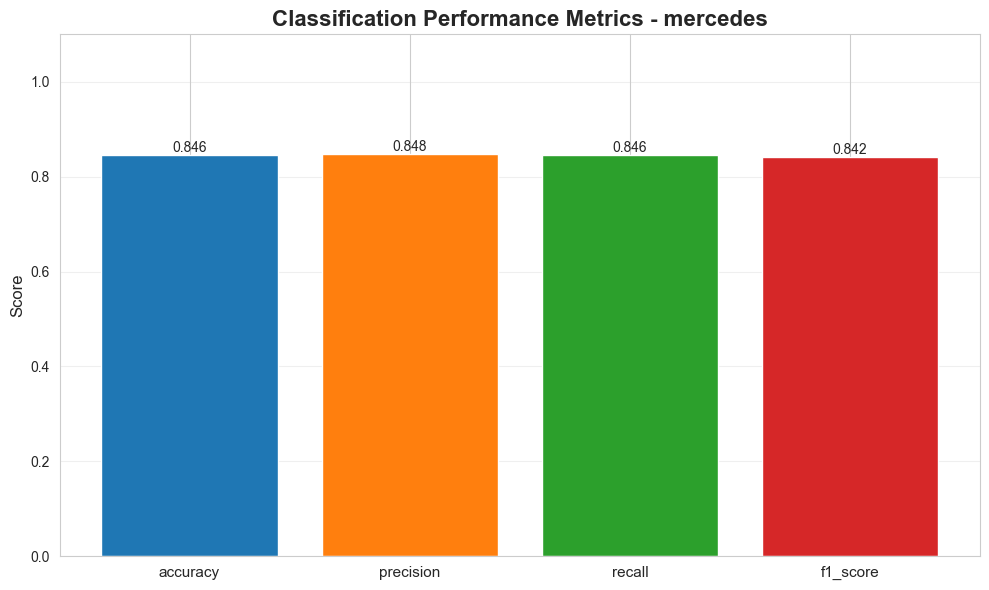

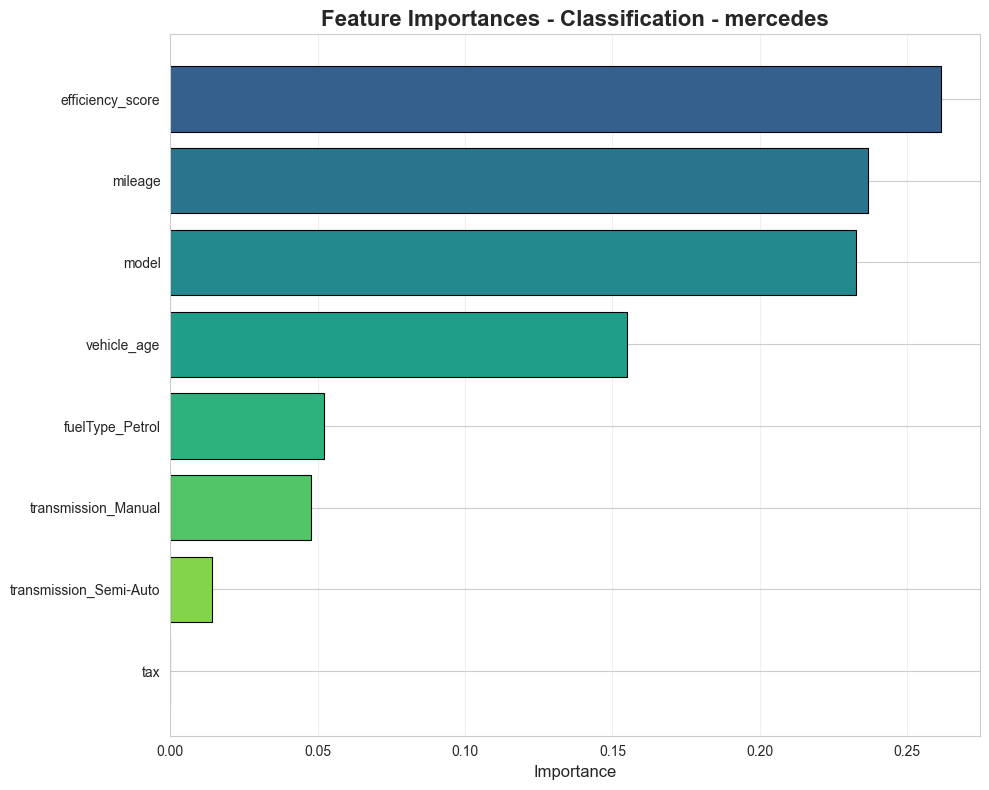

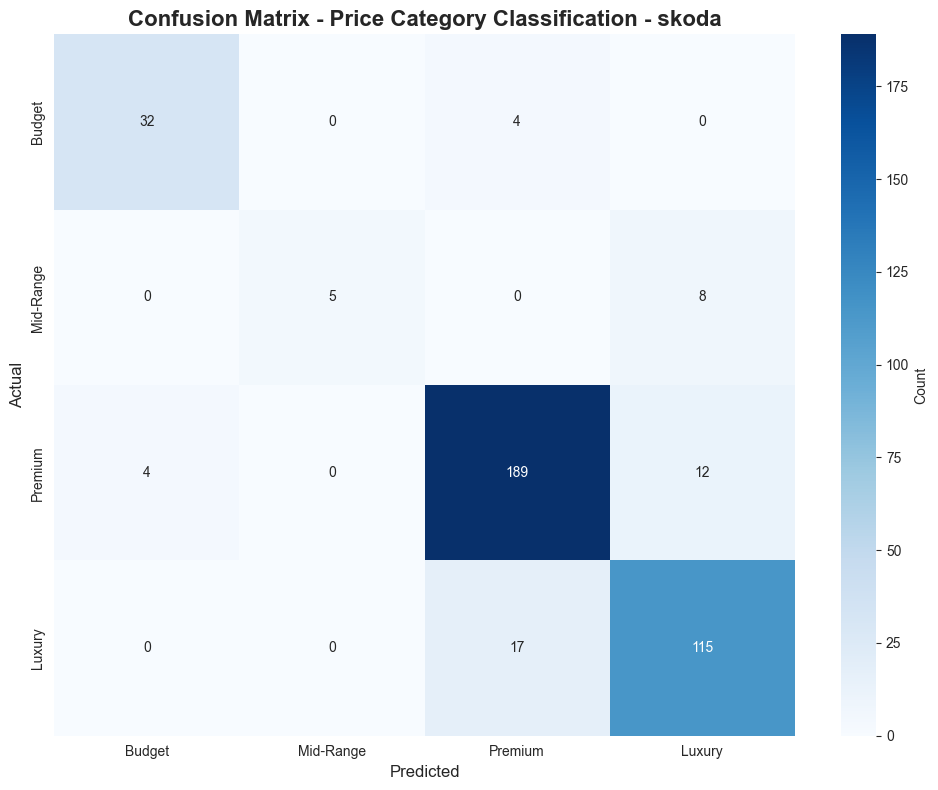

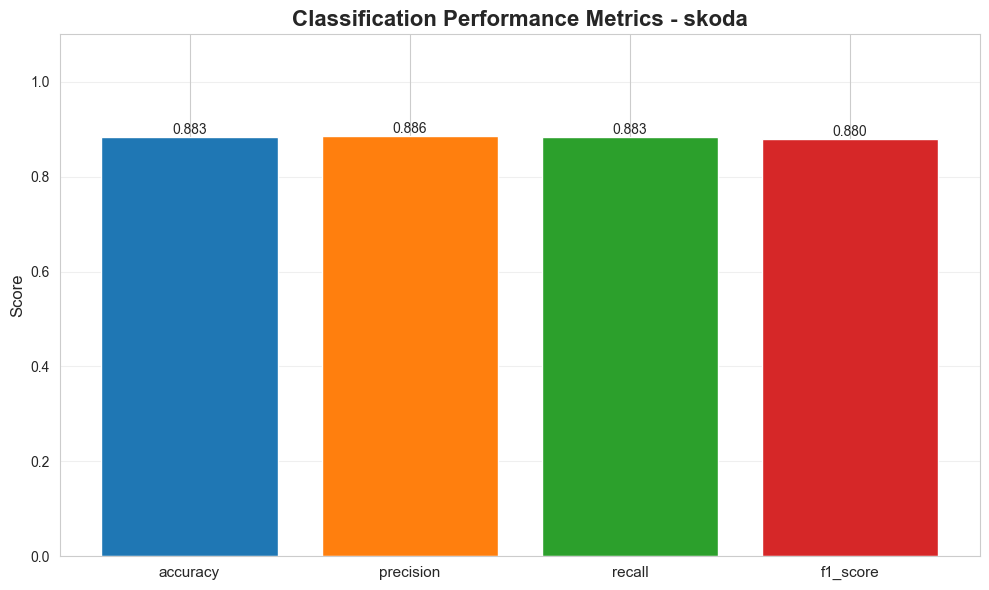

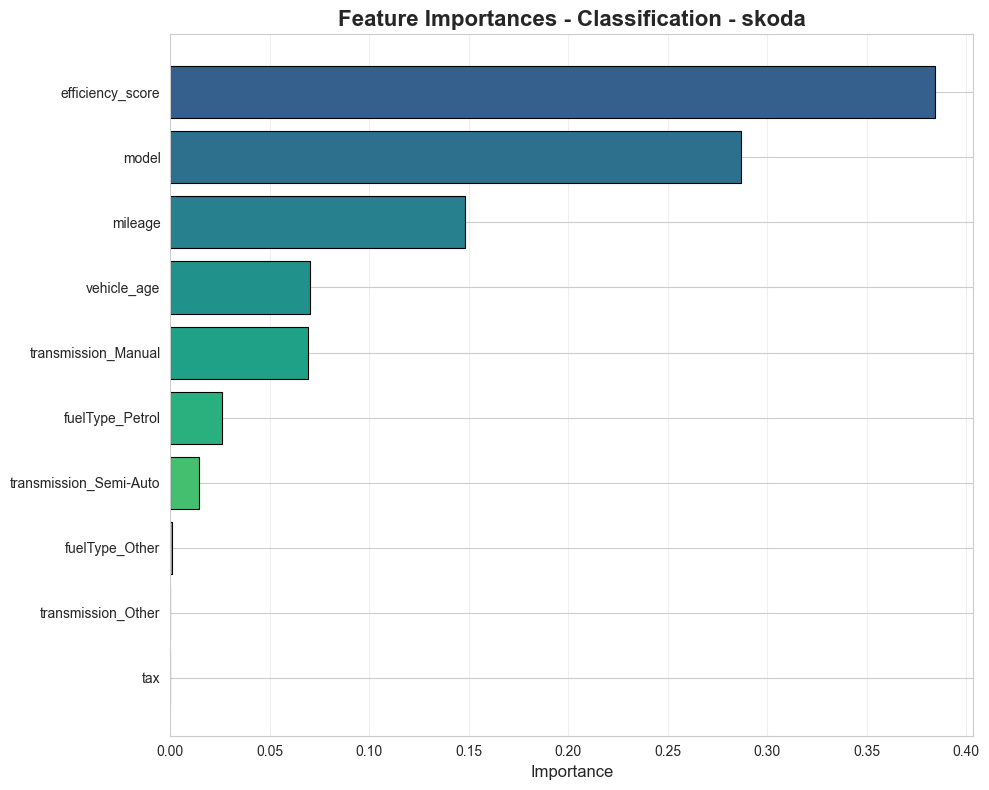

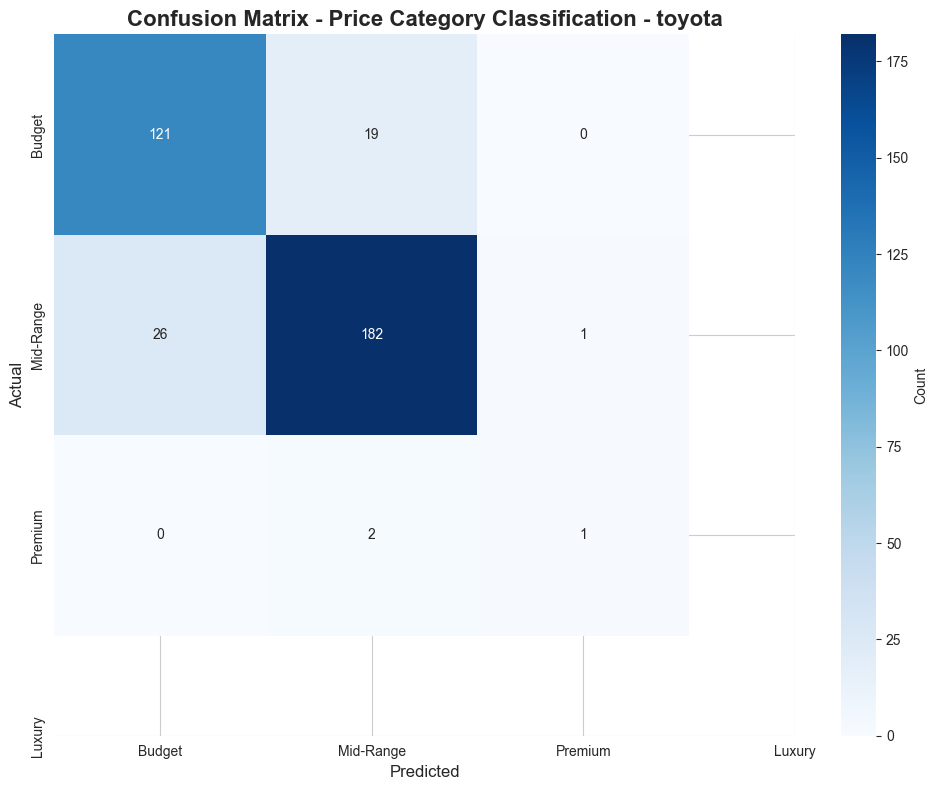

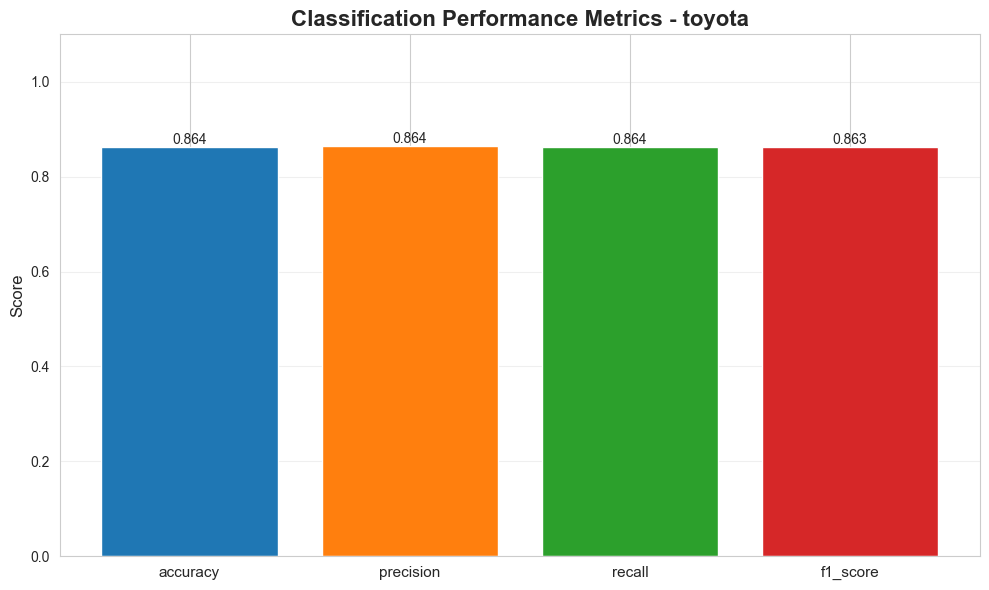

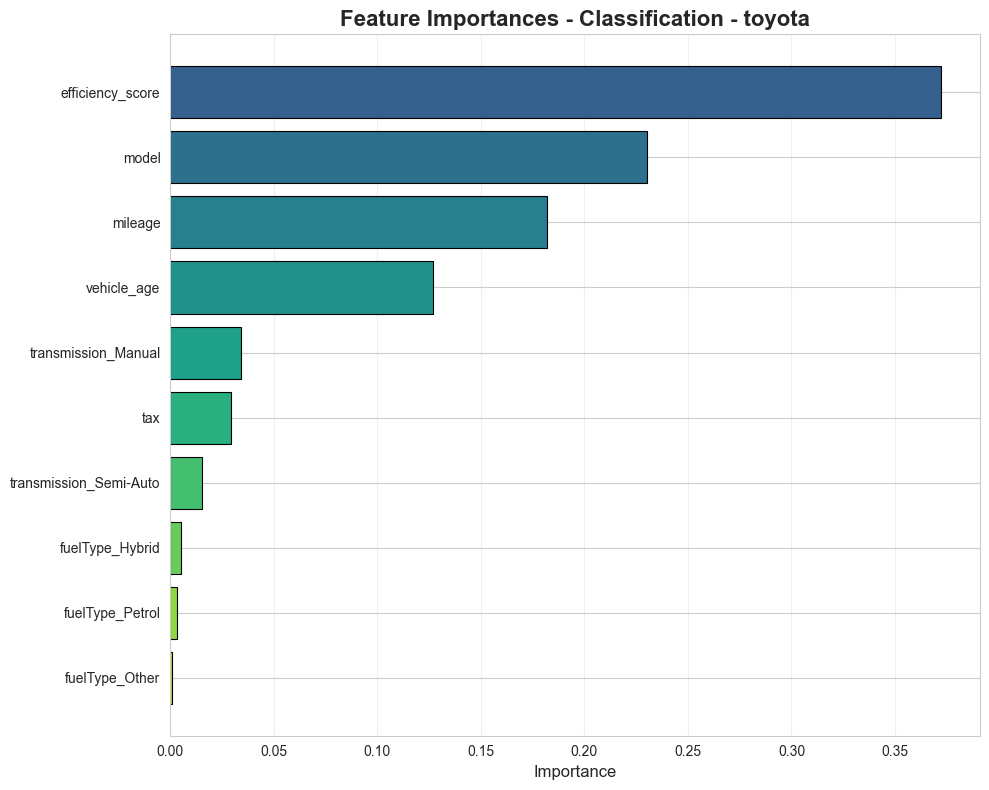

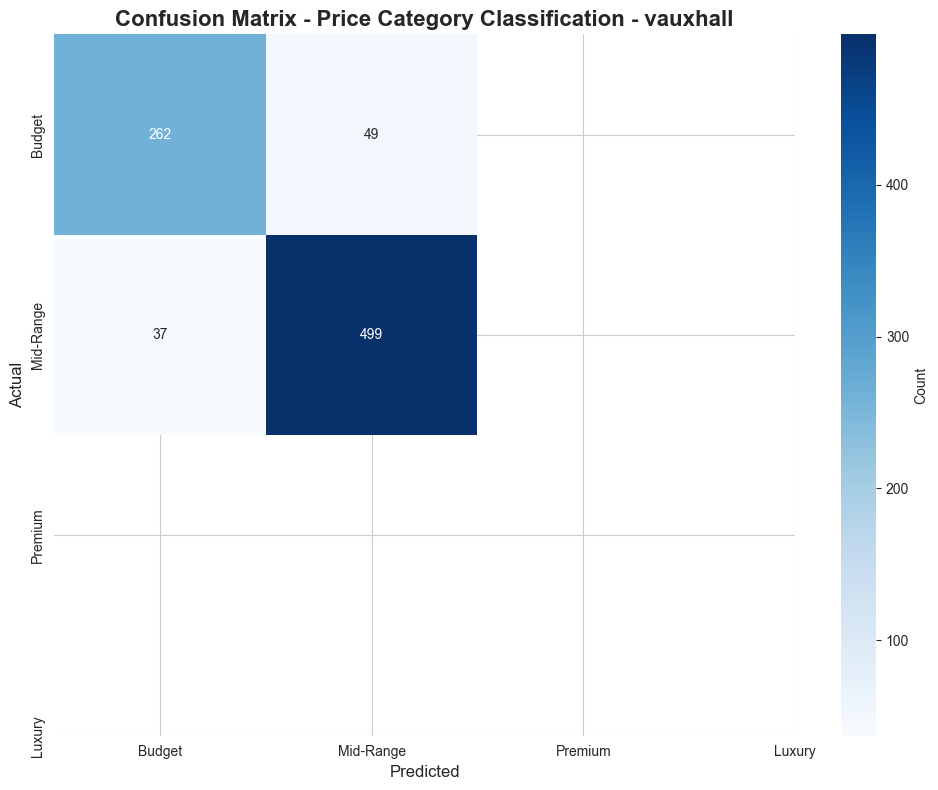

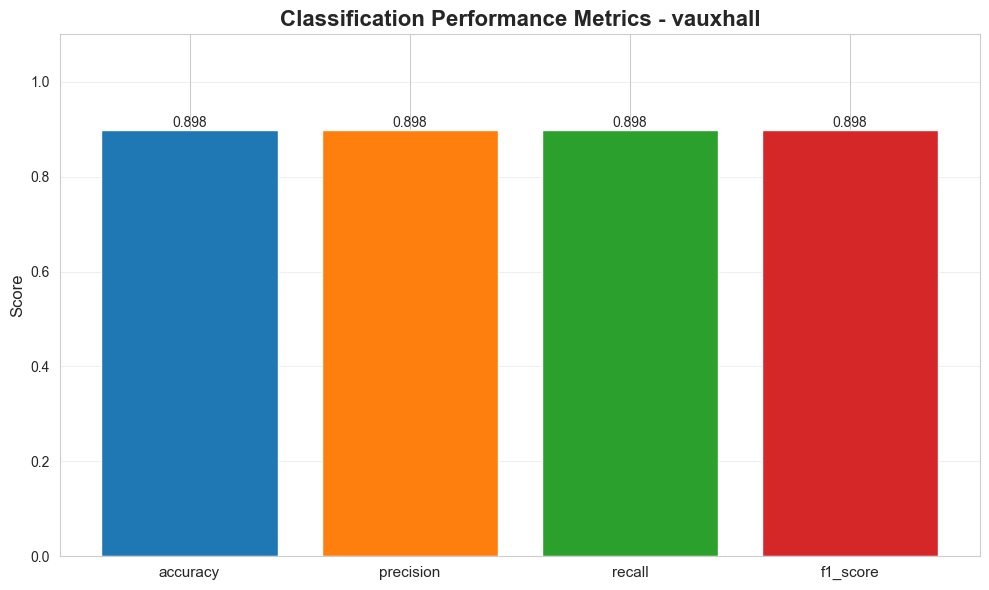

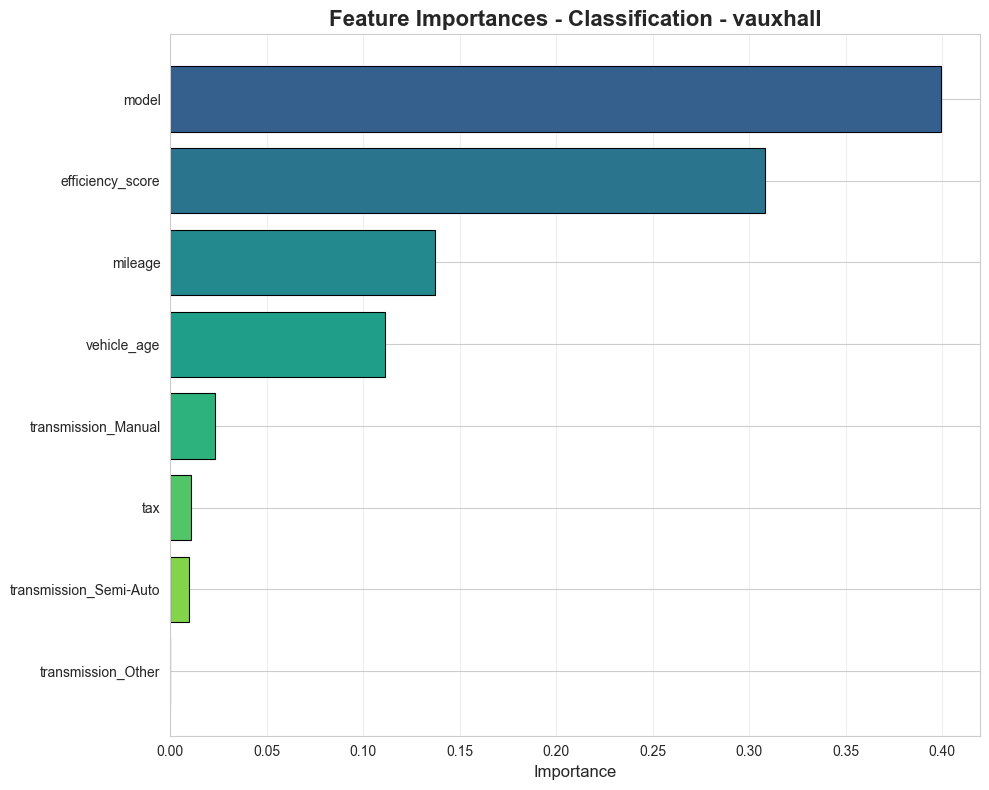

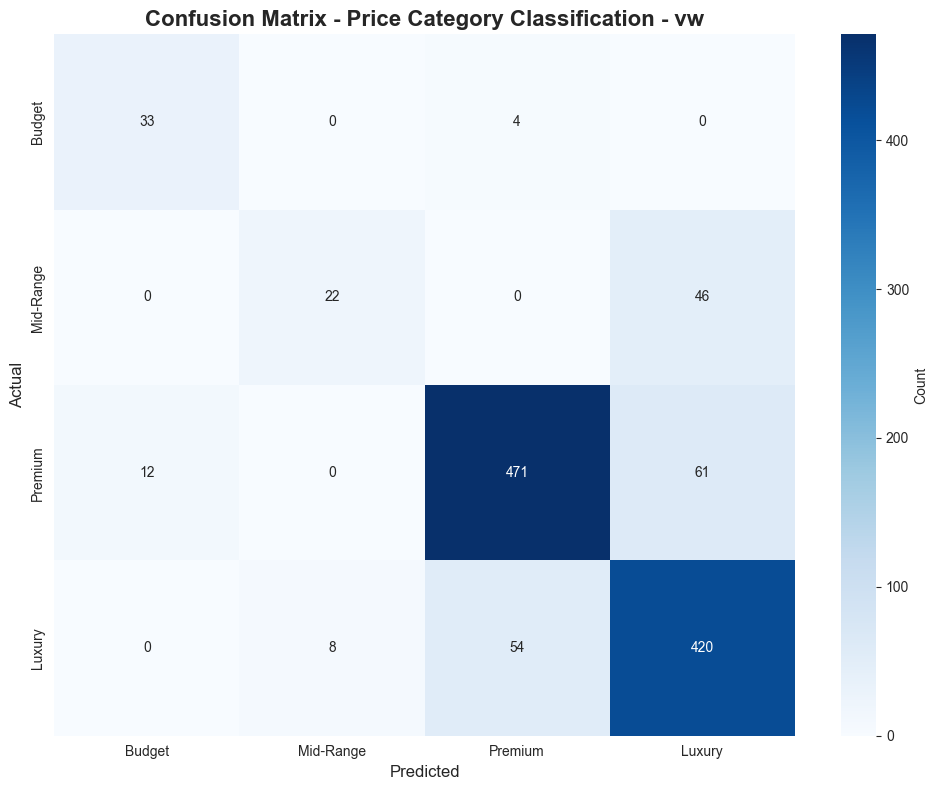

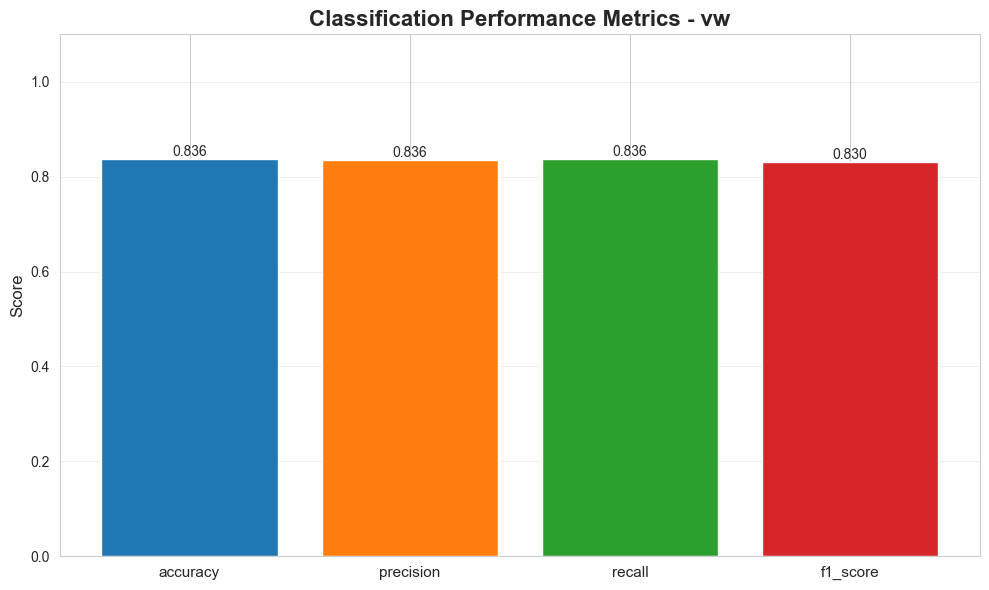

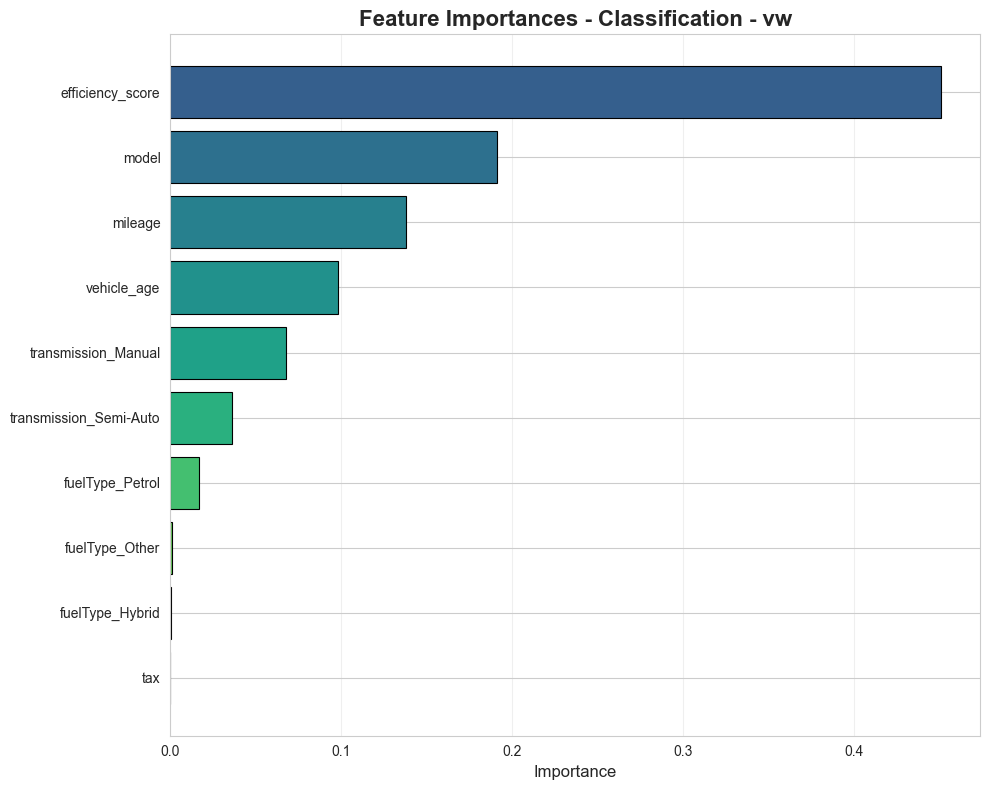

In [11]:
for make_vehicle, data in trained_models_per_make.items():
	model = data["model"]
	y_test = data['y_test']
	feature_names = data["feature_names"]
	predictions = data['predictions']
	metrics = classification_metrics(y_test, predictions)

	n = model.n_features_in_
	feature_names = feature_names[:n]

	plot_confusion_matrix(
		y_test, 
		predictions,
		labels=['Budget', 'Mid-Range', 'Premium', 'Luxury'],
		title=f"Confusion Matrix - Price Category Classification - {make_vehicle}"
	)

	# Classification metrics bar chart
	plot_classification_metrics(
		metrics,
		title=f"Classification Performance Metrics - {make_vehicle}"
	)

	# Feature importances for classification
	values_class, kind_class = get_feature_effects(model)
	plot_feature_importances(
		values_class[:20],
		feature_names[:20],
		f"Feature {kind_class.title()}s - Classification - {make_vehicle}"
	)